# Peace Agreement Mediations Data Explorer



In [1]:
__author__      = 'Roy Gardner'

%run ./mediation_functions.py


## Load the mediation-actor data

- Load data into a biadjacency matrix with mediations in rows and actors in columns
- Matrix values are zero except where a relation between a mediation and an actor exists where the value is an non-zero integer that codes the mediation-actor edge properties.
- Apart from the matrix other data are extracted or computed.
- All data are stored in data_dict




In [2]:

data_path = './data/'
mediation_file = 'mediation.csv'
actors_file = 'actors.csv'

data_dict = load_mediation_data(mediation_file,actors_file,data_path)

print(data_dict['header'])


['year', 'mediation ID', 'negotiation ID', 'conflict locale', 'conflict sub-locale', 'locale Gleditsch ID', 'third-party', 'third-party Gleditsch ID', 'location of neogitations', 'negotiation location Gleditsch ID', 'negotiation type', 'leading actor', 'leading actor 2', 'leading actor 3', 'good offices', 'mediation', 'hosting talks', 'negotiating and drafting', 'manipulating', 'humanitarian', 'witness/party to agreement', 'other', 'agreement', 'peace agreement', 'ceasfire agreement', 'agreement name', 'notes_1', 'source_1', 'note_2', 'source_2', 'note_3', 'source_3', 'note_4', 'source_4', 'note_5', 'source_5', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', '']


## Extract sub-matrix for mediations that result in agreement

(57, 46)


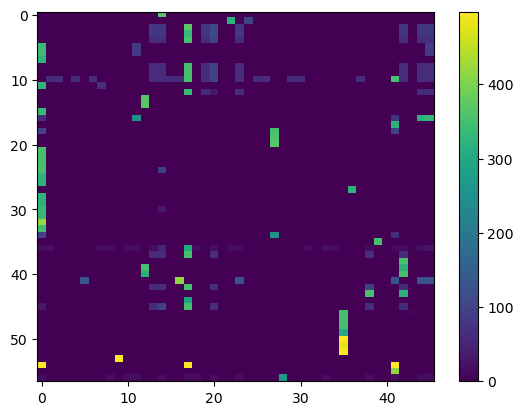

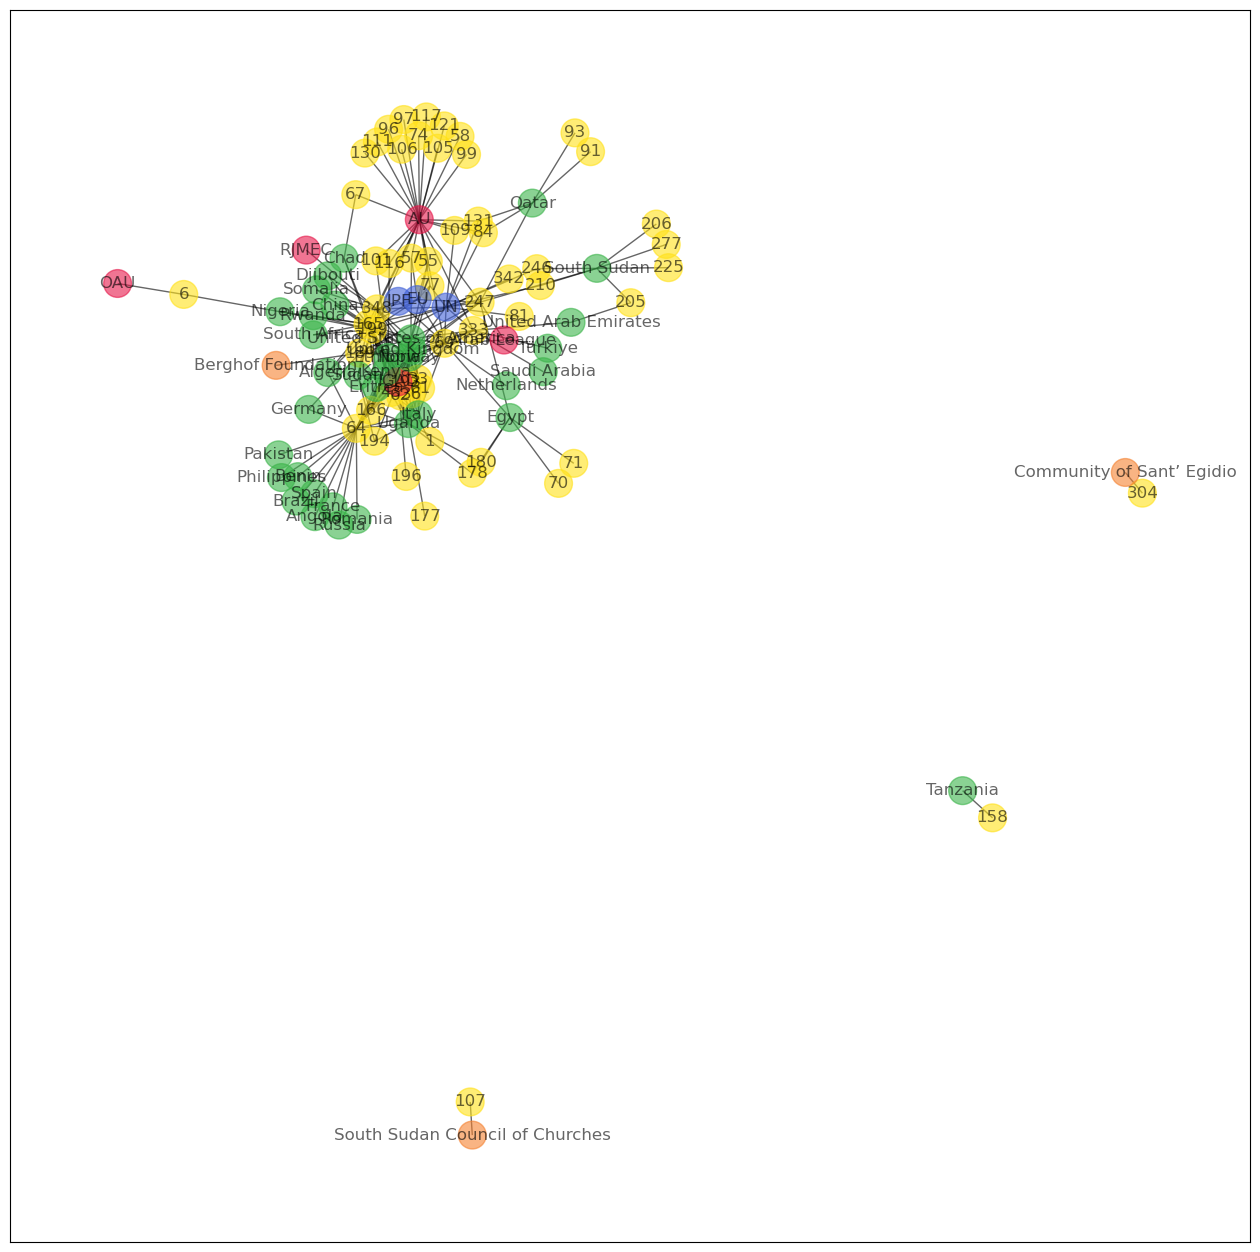

In [7]:
# Get mediation vertices

peace_mediation_ids = [k for k,v in data_dict['vertices_dict'].items() if v['type'] == 'MED' and\
                  v['data']['peace_agreement'] == 1]


peace_mediation_indices = [data_dict['mediation_vertices'].index(v) for v in peace_mediation_ids]


peace_matrix = data_dict['matrix'][np.ix_(peace_mediation_indices,range(0,len(data_dict['actor_vertices'])))]

# Get columns containing non-zero value
indices = np.where(peace_matrix > 0)
peace_actor_indices = list(set(indices[1]))

peace_matrix = peace_matrix[np.ix_(range(0,peace_matrix.shape[0]),peace_actor_indices)]
print(peace_matrix.shape)

peace_actor_ids = [data_dict['actor_vertices'][index] for index in peace_actor_indices]

peace_dict = {}
peace_dict['matrix'] = peace_matrix
peace_dict['mediation_vertices'] = peace_mediation_ids
peace_dict['actor_vertices'] = peace_actor_ids

plt.imshow(peace_matrix,aspect='auto')
plt.colorbar()
plt.show()

adjacency_matrix,adj_vertices = adjacency_from_biadjacency(peace_dict)
bin_matrix = (adjacency_matrix > 0).astype(np.int8)

draw_networkx_graph(bin_matrix,adj_vertices,data_dict)



## Not all actors engage in mediations that result in an agreement

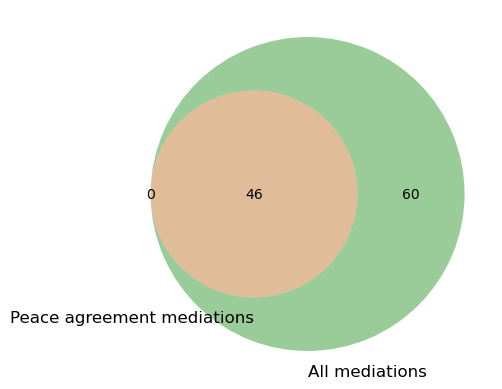


Actors not engaged in peace agreement mediations:

['ACCORD', 'Abel Alier', 'Abyei businessmen', 'African Development Bank', 'African Diplomatic Corps', 'Arab Fund for Social Development', 'Belgium', 'Burundi', 'CTSAMVM', 'Canada', 'Carter Center', 'Christian Relief', 'Croatia', 'Czechia', 'Darfur Security Committee', 'Denmark', 'Episcopal Church of Sudan', 'Equatorial Guinea', 'Equatorian Church Leaders', 'Estonia', 'Fashoda Relief', 'Finland', 'Gabon', 'Ghana', 'Greece', 'Hungary', 'ICC', 'ICRC', 'IMF', 'Ireland', 'Islamic Development Bank', 'James Ellery', 'Japan', 'Kuwait', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Local Murle elites', 'Malta', 'Morocco', 'NGO consortium', 'National Democratic Institute', 'Norwegian Church Aid', 'PAX', 'Poland', 'Portugal', 'Shilluk reth', 'Sierra Leone', 'Slovenia', 'South Sudanese Church Leaders', 'South Sudanese religious leaders', 'Sweden', 'Switzerland', 'The Native Administration', 'The Peaceful Co-Existence Committee', 'The Republic of K

In [5]:
venn2([set(peace_actor_ids),set(data_dict['actor_vertices'])],\
      ['Peace agreement mediations','All mediations'])
plt.show()
print()

print('Actors not engaged in peace agreement mediations:')
print()
print(sorted(list(set(data_dict['actor_vertices']).difference(set(peace_actor_ids)))))


## Lead actor analysis - peace agreement mediations

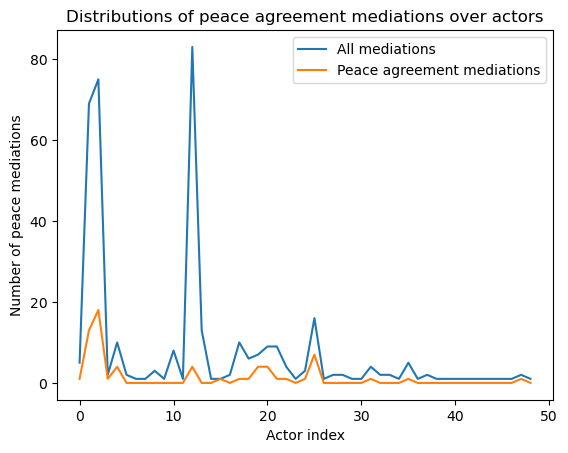


The distributions of peace agreement mediations over actors are highly correlated:
PearsonRResult(statistic=0.8186024477084947, pvalue=6.72854176702811e-13)


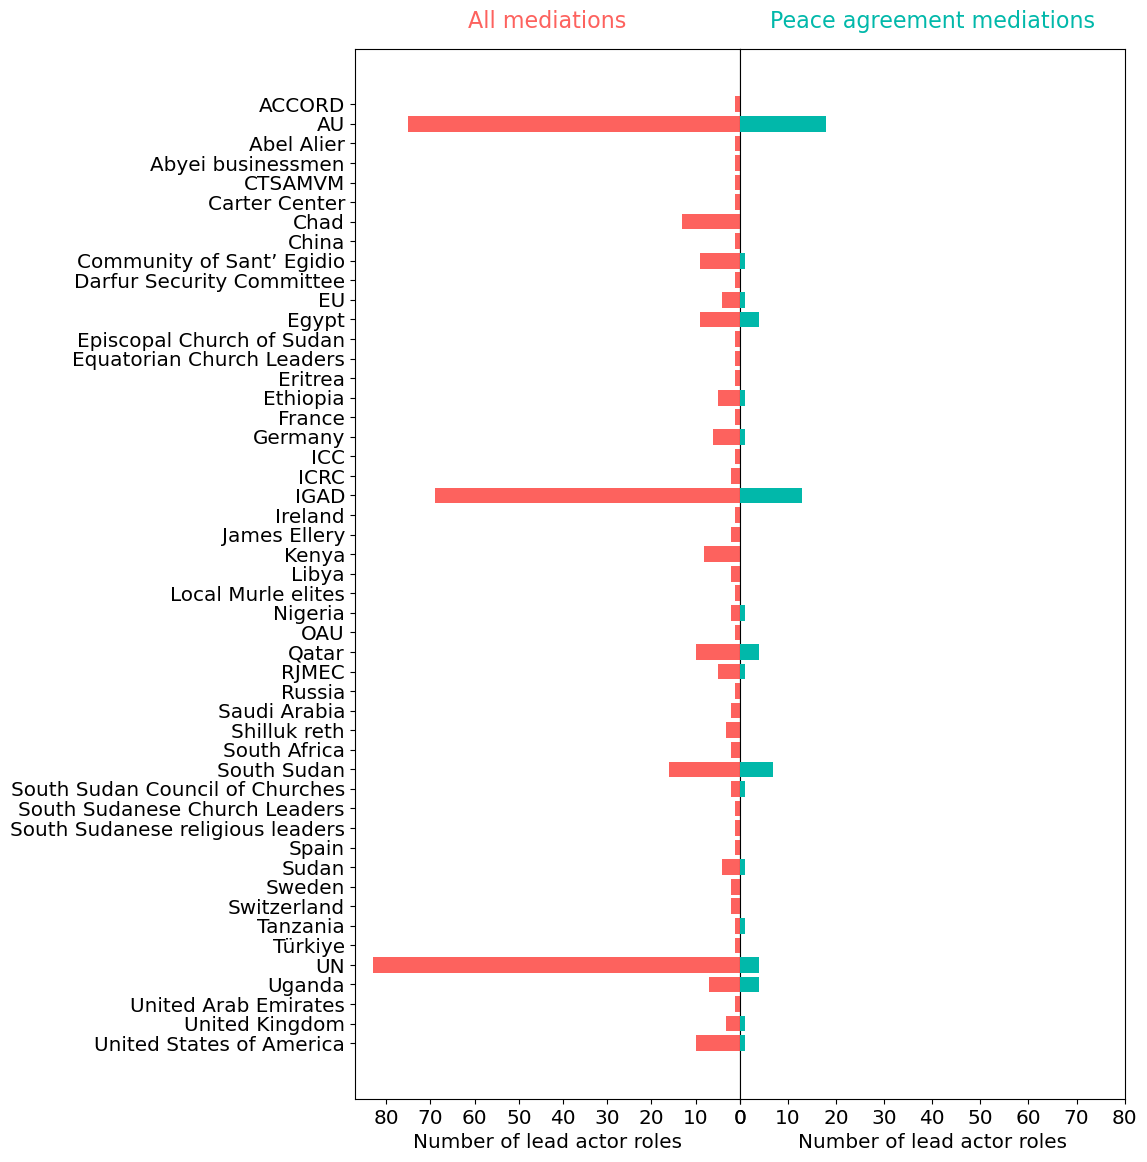

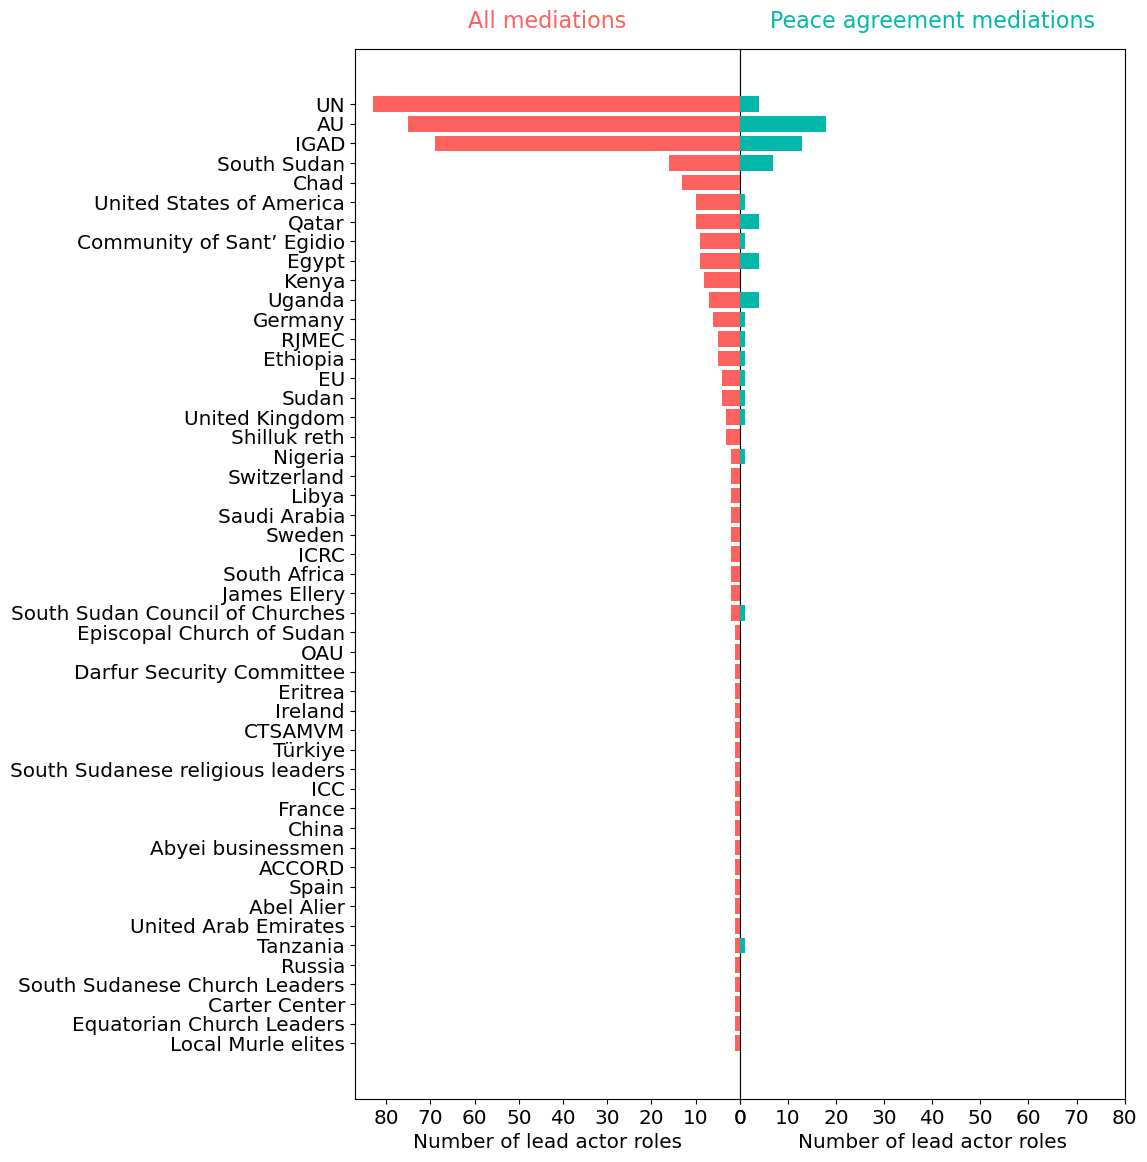

In [41]:
# Collect lead actors from all edges
indices = np.where(data_dict['matrix'] > 0)

lead_counts = {}

for i in range(0,len(indices[0])):
    mediation_index = indices[0][i]
    actor_index = indices[1][i]
    actor_id = data_dict['actor_vertices'][actor_index]
    edge_weight = data_dict['matrix'][mediation_index,actor_index]
    edge_dict = recover_edge_dict(edge_weight,len(get_empty_edge_dict()))
    if int(edge_dict['is_lead']) == 1:
        if actor_id in lead_counts:
            lead_counts[actor_id][0] += 1
        else:
            lead_counts[actor_id] = [1,0]
    
# Collect lead actors from peace matrix edges
indices = np.where(peace_dict['matrix'] > 0)

for i in range(0,len(indices[0])):
    mediation_index = indices[0][i]
    actor_index = indices[1][i]
    actor_id = peace_dict['actor_vertices'][actor_index]
    edge_weight = peace_dict['matrix'][mediation_index,actor_index]
    edge_dict = recover_edge_dict(edge_weight,len(get_empty_edge_dict()))
    if int(edge_dict['is_lead']) == 1:
        if actor_id in lead_counts:
            lead_counts[actor_id][1] += 1
        else:
            lead_counts[actor_id] = [0,1]

plt.plot([v[0] for _,v in lead_counts.items()],label='All mediations')
plt.plot([v[1] for _,v in lead_counts.items()],label='Peace agreement mediations')
plt.ylabel('Number of peace mediations')
plt.xlabel('Actor index')
plt.legend()
plt.title('Distributions of peace agreement mediations over actors')
plt.show()

print()
print('The distributions of peace agreement mediations over actors are highly correlated:')
print(stats.pearsonr([v[0] for _,v in lead_counts.items()],[v[1] for _,v in lead_counts.items()]))

sorted_leads = sorted(lead_counts.items(),key=lambda kv:kv[0],reverse=True)
plot_birectional([(t[0],t[1][0]) for t in sorted_leads],[(t[0],t[1][1]) for t in sorted_leads],\
                 ['All mediations','Peace agreement mediations'],max_x=0,labelled=True,file='')


sorted_leads = sorted(lead_counts.items(),key=lambda kv:kv[1][0])

plot_birectional([(t[0],t[1][0]) for t in sorted_leads],[(t[0],t[1][1]) for t in sorted_leads],\
                 ['All mediations','Peace agreement mediations'],max_x=0,labelled=True,file='')


## Actors co-occurrence matrix

(57, 46)
(46, 46)


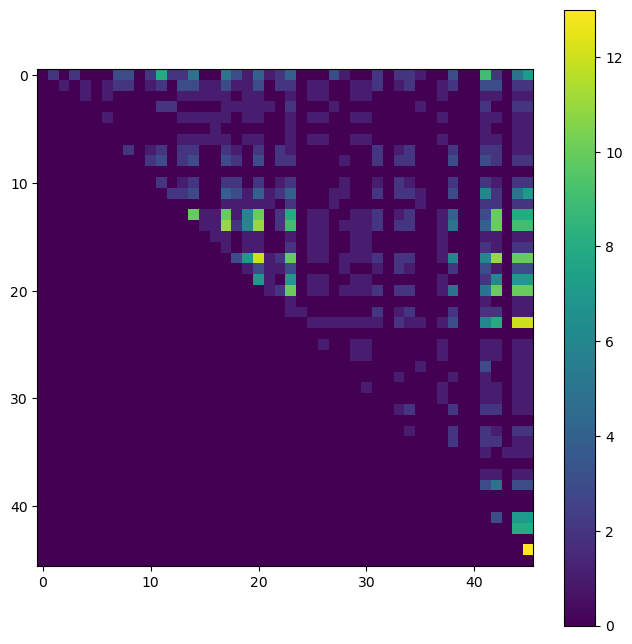

Actors who are co-mediators to the greatest number of peace agreement mediations: ['United Kingdom', 'United States of America']
Number of peace agreement mediations: 13



In [34]:
peace_mediation_ids = [k for k,v in data_dict['vertices_dict'].items() if v['type'] == 'MED' and\
                  v['data']['peace_agreement'] == 1]


peace_mediation_indices = [data_dict['mediation_vertices'].index(v) for v in peace_mediation_ids]


peace_matrix = data_dict['matrix'][np.ix_(peace_mediation_indices,range(0,len(data_dict['actor_vertices'])))]

# Get columns containing non-zero value
indices = np.where(peace_matrix > 0)
peace_actor_indices = list(set(indices[1]))

peace_matrix = peace_matrix[np.ix_(range(0,peace_matrix.shape[0]),peace_actor_indices)]
print(peace_matrix.shape)

peace_actor_ids = [data_dict['actor_vertices'][index] for index in peace_actor_indices]


peace_dict = {}
peace_dict['matrix'] = peace_matrix
peace_dict['mediation_vertices'] = peace_mediation_ids
peace_dict['actor_vertices'] = peace_actor_ids

# Get the co-occurrence matrix
co_matrices = get_cooccurrence_matrices(peace_dict['matrix'])

actor_upper = np.triu(co_matrices[0],k=1)
print(actor_upper.shape)

f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper)
plt.colorbar()
plt.show()

# Actors with max mediations between them
indices = np.unravel_index(np.argmax(actor_upper,axis=None),actor_upper.shape)
actors = [peace_dict['actor_vertices'][index] for index in indices]
print('Actors who are co-mediators to the greatest number of peace agreement mediations:',actors)
print('Number of peace agreement mediations:',actor_upper[indices])
print()


### Recover co-occurence data for highest scoring peace agreement co-mediators

In [33]:
actors = [peace_dict['actor_vertices'][index] for index in indices]
actor_indices = [peace_dict['actor_vertices'].index(actor_id) for actor_id in actors]

# Number in co-occurrence cell
#print(co_matrices[0][actor_indices[0]][actor_indices[1]])

bin_matrix = (peace_dict['matrix'] > 1).astype(np.int8)
# Get the row from the transpose of pp matrix
row1 = bin_matrix.T[actor_indices[0]]
# Get row 2 from the matrix
row2 = bin_matrix.T[actor_indices[1]]

x = np.bitwise_and(row1,row2)

mediation_data = []
for index,value in enumerate(x): 
    if value == 1:
        mediation_id = peace_dict['mediation_vertices'][index]
        mediation_data.append((index,mediation_id,data_dict['vertices_dict'][mediation_id]['data']))
mediation_data = sorted(mediation_data, key=lambda t:t[2]['year'])

print(len(mediation_data))
print()
for data in mediation_data:
    index = data[0]
    edge_dict_1 =\
        recover_edge_dict(peace_dict['matrix'][index,actor_indices[0]],len(get_empty_edge_dict()))
    edge_dict_2 =\
        recover_edge_dict(peace_dict['matrix'][index,actor_indices[1]],len(get_empty_edge_dict()))

    print(data[1],data[2])
    print(actors[0],edge_dict_1)
    print(actors[1],edge_dict_2)
    print()


13

33 {'year': '2002', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'G', 'agreement': 1, 'peace_agreement': 1}
United Kingdom {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '1', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}
United States of America {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '1', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}

36 {'year': '2003', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'G', 'agreement': 1, 'peace_agreement': 1}
United Kingdom {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '1', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}
United States of America {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '1', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}

43